<a href="https://colab.research.google.com/github/ShekharGaikwadDS/PneumoCNN-Deep-Learning-Approach-for-Pneumonia-Detection/blob/main/Pneumonia_Detection_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pneumonia is a serious transmittable disease in India, with 12% of the cases requiring hospitalization and a mortality rate ranging from 3% to 11%**

In [64]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cs
warnings.filterwarnings('ignore')
import seaborn as sns

In [20]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.68.157.138:8470
Number of replicas: 8


In [21]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [22]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [23]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Normal images count in training set: 1349


Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Pneumonia images count in training set: 3883
Total Count of images: 5232


In [24]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [25]:
def get_label(file_path):
    parts = tf.strings.split(file_path, "/")
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [26]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.take(4300)

In [29]:
for image, lable in train_ds.take(1):
  print("Image Shape", image.numpy().shape)

Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Image Shape (224, 224, 3)


In [32]:
test_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

In [37]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Normal images count in test set: 234


Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Pneumonia images count in test set: 390


In [38]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(BATCH_SIZE)

In [40]:
def prepare_for_training(ds, cache=True):  
    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [41]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

In [42]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

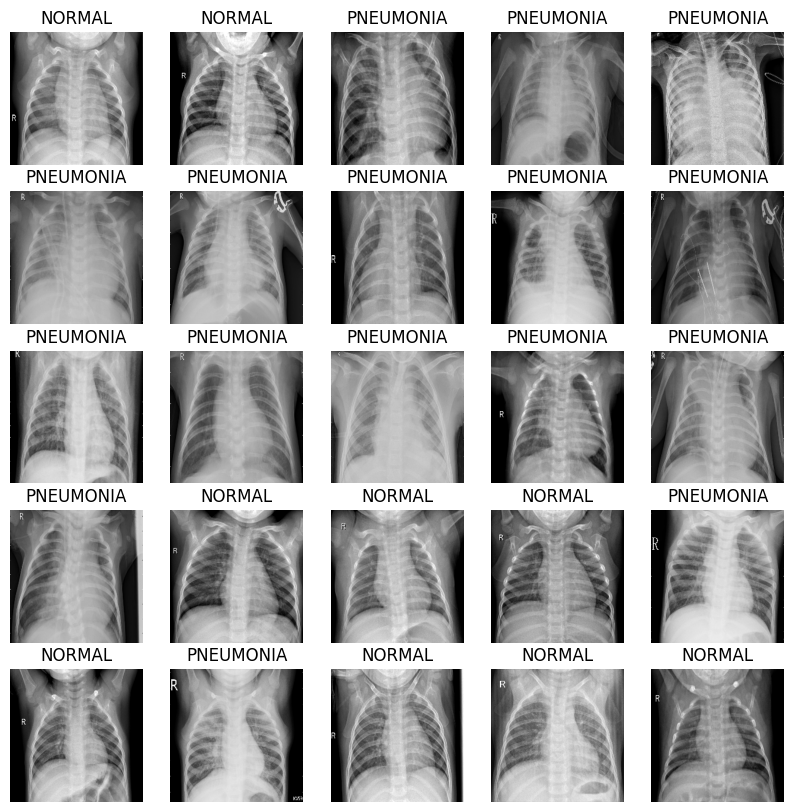

In [43]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [44]:
import tensorflow as tf

In [45]:
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense

from tensorflow.keras import Model

In [46]:
# MobileNet block
def mobilnet_block (x, filters, strides):
    
    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

In [47]:
input = Input(shape = (224, 224, 3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

In [48]:
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
output = Dense (units = 1000, activation = 'softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

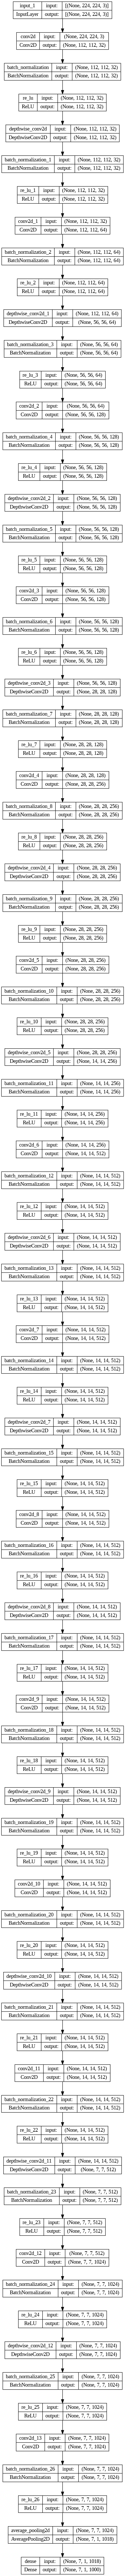

In [49]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [50]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

   
    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False

    
 

    x = mobilenet_model.output    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)                  
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)
    
    return pretrained_model

In [51]:
finetuned_mobilenet = build_model()

9406464/9406464 [==============================] - 1s 0us/step


In [52]:
finetuned_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [53]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

In [54]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [55]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [56]:
with strategy.scope():
  finetuned_mobilenet = build_model()
  METRICS = [
  tf.keras.metrics.BinaryAccuracy(),
  tf.keras.metrics.Precision(name="precision"),
  tf.keras.metrics.Recall(name="recall"),
  ]
  finetuned_mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=METRICS,
  )

  history = finetuned_mobilenet.fit(
  train_ds_batch,
  epochs = 10,
  validation_data = val_ds_batch,
  class_weight = class_weight,
  callbacks=[checkpoint_cb,early_stopping_cb,lr_scheduler]
  )

Epoch 1/10
17/17 [==============================] - 50s 2s/step - loss: 0.9189 - binary_accuracy: 0.8319 - precision: 0.9243 - recall: 0.8414 - val_loss: 0.4153 - val_binary_accuracy: 0.8337 - val_precision: 0.9929 - val_recall: 0.7829 - lr: 0.0100
Epoch 2/10
17/17 [==============================] - 7s 411ms/step - loss: 0.2549 - binary_accuracy: 0.9072 - precision: 0.9646 - recall: 0.9078 - val_loss: 0.3976 - val_binary_accuracy: 0.8107 - val_precision: 0.7982 - val_recall: 0.9991 - lr: 0.0089
Epoch 3/10
17/17 [==============================] - 4s 250ms/step - loss: 0.1852 - binary_accuracy: 0.9247 - precision: 0.9792 - recall: 0.9176 - val_loss: 0.7287 - val_binary_accuracy: 0.7500 - val_precision: 0.7491 - val_recall: 1.0000 - lr: 0.0079
Epoch 4/10
17/17 [==============================] - 4s 220ms/step - loss: 0.1559 - binary_accuracy: 0.9388 - precision: 0.9818 - recall: 0.9346 - val_loss: 0.6677 - val_binary_accuracy: 0.7537 - val_precision: 0.7519 - val_recall: 1.0000 - lr: 0.007

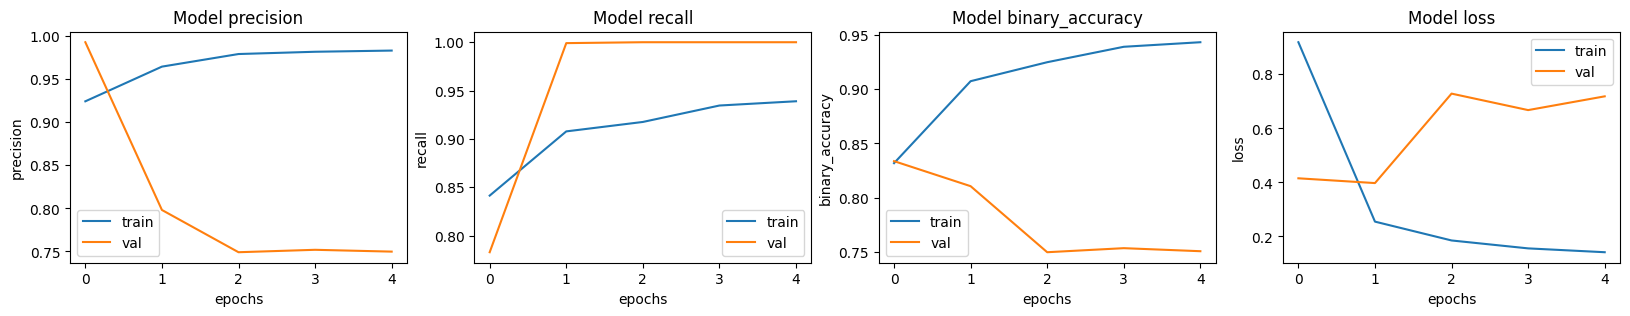

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [58]:
loaded_mobilenet = tf.keras.models.load_model('xray_model.h5')

In [59]:
loaded_mobilenet.evaluate(test_ds_batch, return_dict=True)

3/3 [==============================] - 4s 339ms/step - loss: 1.1145 - binary_accuracy: 0.6314 - precision: 0.6294 - recall: 0.9974


{'loss': 1.1144657135009766,
 'binary_accuracy': 0.6314102411270142,
 'precision': 0.6294498443603516,
 'recall': 0.9974358677864075}

Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


2/2 [==============================] - 11s 84ms/step
This image is 3.46 percent NORMAL
This image is 96.54 percent PNEUMONIA
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


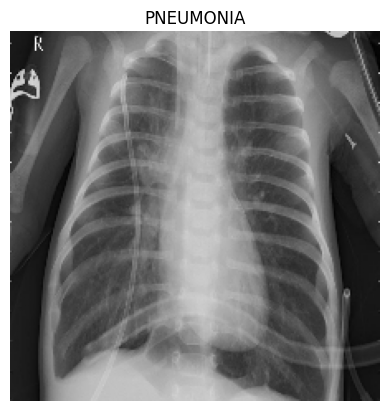

In [60]:
for image, label in test_ds_batch.take(2):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
%time

In [61]:
label_list = []
prediction_list = []

for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image)
    label = tf.where(label, 1, 0)
    
    if prediction > 0.5 :
        prediction = 1
    else : 
        prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)

1/1 [==============================] - 1s 505ms/step


Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [62]:
test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)

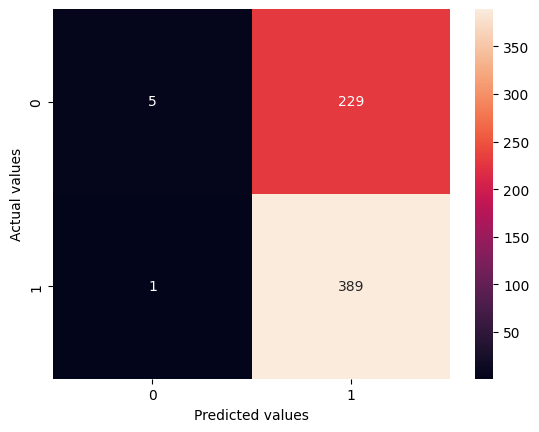

In [65]:
ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')

plt.show()

In [67]:
for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)


4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


In [68]:
last_conv_layer_name = finetuned_mobilenet.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

In [69]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00


Exception ignored in: <function Executor.__del__ at 0x7fa9ff33ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


2/2 [==============================] - 2s 86ms/step
This image is 3.46 percent NORMAL
This image is 96.54 percent PNEUMONIA


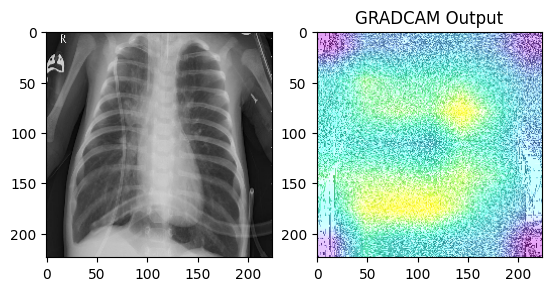

In [70]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):
    
    data = ([image[2].numpy()], None)
    
    image = image[2] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
    

explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0)  

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(grid)
axarr[1].title.set_text('GRADCAM Output')
plt.show()